In [1]:
import torch, torchvision
import os
import random
import dataset
import metrics
import time

import constants as cst
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

import loss_fn_v2 as loss_fn
from unet import UNET

In [2]:
random.seed(cst.SEED)
torch.manual_seed(cst.SEED)
np.random.seed(cst.SEED)

def predict_img(model, image, device, transform, out_threshold=0.5):
    with torch.no_grad():
        x = image
        logits = model(x.to(device))
        logits = transform(logits)
        y_pred = nn.Softmax(dim=1)(logits)
        proba = y_pred.detach().cpu().squeeze(0).numpy()[1, :, :]
        return proba > out_threshold

In [3]:
TERMS = ["n"]
SIZE = (384, 512)
FOLDS = [0, 1, 2, 3, 4]    # 0 to 4 only 1 fold at a time here for computational resources limit

DEVICE_NAME = "cpu"
if torch.cuda.is_available():
    DEVICE_NAME = 'cuda:0'
DEVICE = torch.device(DEVICE_NAME)

Starting term: n
Starting fold: 0
Training set length: 70
Validation set length: 18
Pre-testing set length: 17
Focal
Epoch: 5
Validation: 0.002111488743685186.
Best: 0.002111488743685186.
Epoch: 10
Validation: 0.0013128872960805893.
Best: 0.0013128872960805893.


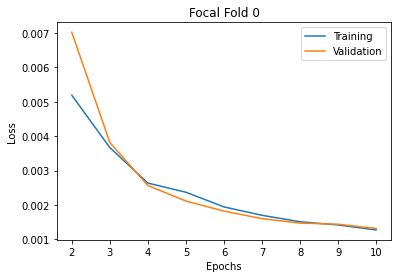

--------------------
Term: n
Fold: 0
Fold took: 3.0 minutes 7.951275110244751 seconds to train
Last val: 0.0013128872960805893
Best val: 0.0013128872960805893

Precision: 0.9557702625778757
90% CI: [0.85581179 1.        ]
Min, max: 0.7009185185181032 0.9999999999994855

Recall: 0.7770435623379184
90% CI: [0.53400605 0.91506415]
Min, max: 0.4396855029796655 0.9253058954388624

F1/Dice score: 0.8472997356539351
90% CI: [0.69321124 0.93046767]
Min, max: 0.6106249844188641 0.9344684220944035

IoU: 0.7434957392571782
90% CI: [0.53192964 0.86998275]
Min, max: 0.43949616019506227 0.8769973987361218

--------------------
Starting fold: 1
Training set length: 70
Validation set length: 18
Pre-testing set length: 17
Focal
Epoch: 5
Validation: 0.002541890135034919.
Best: 0.002541890135034919.
Epoch: 10
Validation: 0.0015548474388197065.
Best: 0.0015548474388197065.


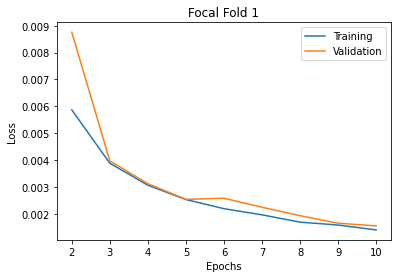

--------------------
Term: n
Fold: 1
Fold took: 3.0 minutes 5.459150791168213 seconds to train
Last val: 0.0015548474388197065
Best val: 0.0015548474388197065

Precision: 0.9097187821571456
90% CI: [0.70788293 0.99123875]
Min, max: 0.6621450625091552 0.9966336941317537

Recall: 0.884962714657161
90% CI: [0.7712154  0.97817645]
Min, max: 0.7342796092793291 0.9811009449520165

F1/Dice score: 0.8921182172168569
90% CI: [0.78377575 0.94344385]
Min, max: 0.7562061052776656 0.953587934808817

IoU: 0.8089045701448536
90% CI: [0.64464132 0.8929864 ]
Min, max: 0.6079834516686399 0.9112929471379835

--------------------
Starting fold: 2
Training set length: 70
Validation set length: 18
Pre-testing set length: 17
Focal
Epoch: 5
Validation: 0.006119506806135178.
Best: 0.006119506806135178.
Epoch: 10
Validation: 0.003807531064376235.
Best: 0.003807531064376235.


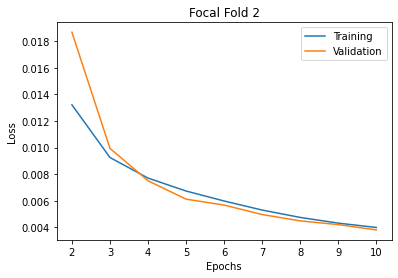

--------------------
Term: n
Fold: 2
Fold took: 3.0 minutes 2.456493854522705 seconds to train
Last val: 0.003807531064376235
Best val: 0.003807531064376235

Precision: 0.9135438133440217
90% CI: [0.78959366 0.98258108]
Min, max: 0.6127655626678667 0.9946742936037306

Recall: 0.8735743175935398
90% CI: [0.79333545 0.95888561]
Min, max: 0.7709116645283448 0.9995460048418586

F1/Dice score: 0.8875821214410018
90% CI: [0.82954112 0.93561353]
Min, max: 0.7597630413525164 0.9422636859705725

IoU: 0.8004837233598403
90% CI: [0.71018603 0.87903517]
Min, max: 0.6125950658502075 0.8908304210347433

--------------------
Starting fold: 3
Training set length: 71
Validation set length: 17
Pre-testing set length: 17
Focal
Epoch: 5
Validation: 0.004026501905173063.
Best: 0.004026501905173063.
Epoch: 10
Validation: 0.0026049673091620208.
Best: 0.0026049673091620208.


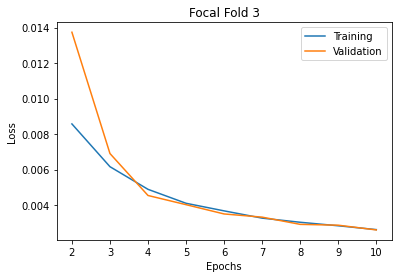

--------------------
Term: n
Fold: 3
Fold took: 3.0 minutes 1.1303150653839111 seconds to train
Last val: 0.0026049673091620208
Best val: 0.0026049673091620208

Precision: 0.9091727364669095
90% CI: [0.78473997 0.99467189]
Min, max: 0.6203625434391752 0.9964883730885201

Recall: 0.8782307056939745
90% CI: [0.79198825 0.97337304]
Min, max: 0.7629779024900197 0.9988657844982994

F1/Dice score: 0.8879450647983236
90% CI: [0.81661002 0.93799057]
Min, max: 0.7653755902544207 0.9413099077057843

IoU: 0.8009642511075451
90% CI: [0.69082736 0.88322707]
Min, max: 0.6199258529257028 0.8891269641202886

--------------------
Starting fold: 4
Training set length: 71
Validation set length: 17
Pre-testing set length: 17
Focal
Epoch: 5
Validation: 0.002206487813964486.
Best: 0.002206487813964486.
Epoch: 10
Validation: 0.0015520881628617645.
Best: 0.0015520881628617645.


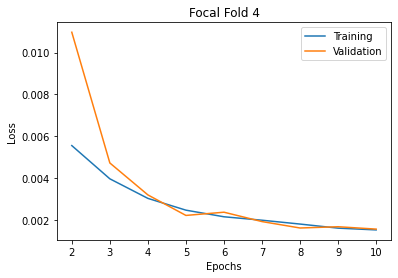

--------------------
Term: n
Fold: 4
Fold took: 3.0 minutes 4.974881172180176 seconds to train
Last val: 0.0015520881628617645
Best val: 0.0015520881628617645

Precision: 0.903642131841283
90% CI: [0.65868532 0.99876001]
Min, max: 0.6471366286187002 0.9993639299339468

Recall: 0.8605990871268421
90% CI: [0.75776846 0.9523747 ]
Min, max: 0.7531704299409399 0.9994703790565185

F1/Dice score: 0.8743183808893528
90% CI: [0.77976127 0.9339885 ]
Min, max: 0.7563740028046173 0.9421687341239138

IoU: 0.7803884355267876
90% CI: [0.63917194 0.87618015]
Min, max: 0.6082005398008621 0.8906606984655706

--------------------

ALL FOLDS TRAINING ENDED
Mean best validation: 0.0021664642542600634
Mean precision: 0.9183695452774471
Mean recall: 0.8548820774818872
Mean F1: 0.877852703999894
Mean IOU: 0.7868473438792408



In [4]:
for TERM in TERMS:
    print("Starting term: " + TERM)
    start_term = time.time()
    
    DATASET = "/notebooks/images"
    MASKS = "/notebooks/" + TERM
    
    transform = transforms.Compose([transforms.Resize(SIZE),
                                    transforms.Pad((0, 64, 0, 64))])
    untransform = transforms.Compose([transforms.CenterCrop(SIZE),
                                     transforms.Resize((1932, 2576))])
    
    fold_validation = []
    fold_precision = []
    fold_recall = []
    fold_f1 = []
    fold_IOU = []
    
    for fold in FOLDS:
        print("Starting fold: {}".format(fold))
        start_fold = time.time()
        """Datasets and loaders"""
        image_folder = DATASET
        mask_folder = MASKS
        training_set = dataset.ZebrafishDataset_KFold_v2(image_folder,
                                                      mask_folder,
                                                      actual_fold=fold,
                                                      dataset="train",
                                                      folds=cst.FOLDS)
        validation_set = dataset.ZebrafishDataset_KFold_v2(image_folder,
                                                        mask_folder,
                                                        actual_fold=fold,
                                                        dataset="validate",
                                                        folds=cst.FOLDS)
        testing_set = dataset.ZebrafishDataset_KFold_v2(image_folder,
                                                     mask_folder,
                                                     actual_fold=fold,
                                                     dataset="pre-test",
                                                     folds=cst.FOLDS)

        training_loader = torch.utils.data.DataLoader(training_set,
                                                      batch_size=cst.BATCH_SIZE,
                                                      shuffle=True,
                                                      num_workers=cst.WORKERS)

        validation_loader = torch.utils.data.DataLoader(validation_set,
                                                        batch_size=cst.BATCH_SIZE,
                                                        shuffle=True,
                                                        num_workers=cst.WORKERS)

        testing_loader = torch.utils.data.DataLoader(testing_set,
                                                     batch_size=1,
                                                     shuffle=True,
                                                     num_workers=cst.WORKERS)
        
        model = UNET(3, 2)
        model.to(DEVICE)
        best_model = UNET(3, 2)
        best_model = model
        
        criterion = nn.CrossEntropyLoss()
        criterion_string = "CE"

        if cst.LOSS == "Dice":
            print("Dice")
            criterion = loss_fn.DiceLoss()
            criterion_string = "DCE"
        if cst.LOSS == "IOU":
            print("IOU")
            criterion = loss_fn.IoULoss()
            criterion_string = "IOU"
        if cst.LOSS == "Tversky":
            print("Tversky")
            criterion = loss_fn.TverskyLoss(alpha=0.7, beta= 0.3)
            criterion_string = "Tversky"
        if cst.LOSS == "Focal":
            print("Focal")
            criterion = loss_fn.FocalLoss(alpha=0.8, gamma= 2, reduction="mean")
            criterion_string = "Focal"

        optimiser = torch.optim.Adam(model.parameters(), lr=cst.LEARNING_RATE, weight_decay=cst.WEIGHT_DECAY)
        optimiser_string = "ADAM" + "_" + "LR" + str(cst.LEARNING_RATE) + "_" + "WD" + str(cst.WEIGHT_DECAY)
        
        if cst.OPTIMIZER == "SGD":
            optimizer = torch.optim.SGD(model.parameters(),
                                        lr=cst.LEARNING_RATE,
                                        momentum=cst.MOMENTUM,
                                        weight_decay=cst.WEIGHT_DECAY)
            optimiser_string = "SGD" + "_" + "LR" + str(cst.LEARNING_RATE) + "_" + "M" + str(cst.MOMENTUM)
            optimiser_string += "_" + "WD" + str(cst.WEIGHT_DECAY)
        
        params_string = "Params" + "_" + "Epoch" + str(cst.EPOCHS) + "_" + "BS" + str(cst.BATCH_SIZE)
        params_string += "_" + "W" + str(cst.WORKERS)
        
        """Computing validation loss before training"""
        model.eval()
        with torch.no_grad():
            val_loss = []
            for images, masks, names in validation_loader:
                images = transform(images)
                outputs = model(images.to(DEVICE))
                outputs = untransform(outputs)

                masks = masks.type(torch.LongTensor)
                masks = torch.squeeze(masks, 1)

                vloss = criterion(outputs, masks.to(DEVICE))
                loss = vloss.detach().item()
                val_loss.append(loss)

            loss = np.mean(val_loss)
            # print("Validation loss before training: {}".format(loss))
            
        best_val = loss
        best_epoch = 0
        
        epochs_train_losses = []
        epochs_val_losses = []
        for epoch in range(cst.EPOCHS):
            # Training
            model.train()
            train_loss = []
            for images, masks, names in training_loader:
                images = transform(images)
                outputs = model(images.to(DEVICE))
                outputs = untransform(outputs)

                masks = masks.type(torch.LongTensor)
                masks = torch.squeeze(masks, 1)

                tloss = criterion(outputs, masks.to(DEVICE))
                loss = tloss.detach().item()
                train_loss.append(loss)

                optimiser.zero_grad()
                tloss.backward()
                optimiser.step()

            loss = np.mean(train_loss)
            epochs_train_losses.append(loss)
            #print("Trained: {}".format(loss), end=". ")

            """Validation"""
            model.eval()
            with torch.no_grad():
                val_loss = []
                for images, masks, names in validation_loader:
                    images = transform(images)
                    outputs = model(images.to(DEVICE))
                    outputs = untransform(outputs)

                    masks = masks.type(torch.LongTensor)
                    masks = torch.squeeze(masks, 1)

                    vloss = criterion(outputs, masks.to(DEVICE))
                    loss = vloss.detach().item()
                    val_loss.append(loss)

                loss = np.mean(val_loss)
                epochs_val_losses.append(loss)
                
                if loss < best_val:
                    best_val = loss
                    best_model = model
                    best_epoch = epoch+1
                
                if (epoch+1)%5 == 0:
                    print("Epoch: " + str(epoch+1))
                    #print("Training: {}".format(np.mean(train_loss)))
                    print("Validation: {}.".format(loss))
                    print("Best: {}.".format(best_val))
                    
            """Train and validate loops over"""
        """All epochs are over"""
        
        fold_validation.append(best_val)
        
        model_name = TERM + '_' + cst.LOSS + "_Fold_" + str(fold) + "_Epoch_" + str(best_epoch) + "_MaxEpochs_" 
        model_name += str(cst.EPOCHS) + '_' + cst.OPTIMIZER + "_LR_" + str(cst.LEARNING_RATE) + ".pth"
        
        model_filepath = os.path.join(cst.MODEL, model_name)
        #torch.save(best_model.state_dict(), model_filepath)
        
        curr = time.time()
        curr = curr - start_fold
        secondes = curr % 60
        minutes = (curr-secondes)/60
        
        index = [i+1 for i in range(cst.EPOCHS)]
        plt.plot(index[1:], epochs_train_losses[1:], label="Training")
        plt.plot(index[1:], epochs_val_losses[1:], label="Validation")
        plt.title(str(cst.LOSS) + " Fold " + str(fold)) 
        plt.ylabel("Loss")
        plt.xlabel("Epochs")
        plt.legend()
        plt.show()
        #name = model_name[:-4]
        #plot_name = name + ".png"
        #plt.savefig(plot_name)
        
        tps = 0
        precisions = []
        recalls = []
        F1s = []
        IOUs = []

        eval_model = UNET(3, 2)
        eval_model = best_model

        eval_model.eval()
        for image, mask, name in testing_loader:
            image_name = name[0]
            prediction = predict_img(eval_model, transform(image), DEVICE, untransform, out_threshold=cst.THRESHOLD)
            pred = torch.from_numpy(prediction)

            precisions.append(metrics.precision(pred, mask))
            recalls.append(metrics.recall(pred, mask))
            F1s.append(metrics.F1Score(pred, mask))
            IOUs.append(metrics.IOUScore(pred, mask))
        
        mean_precision = np.mean(precisions)
        mean_recall = np.mean(recalls)
        mean_f1 = np.mean(F1s)
        mean_IOU = np.mean(IOUs)
        
        fold_precision.append(mean_precision)
        fold_recall.append(mean_recall)
        fold_f1.append(mean_f1)
        fold_IOU.append(mean_IOU)
        
        confidence = 0.9
        
        print("--------------------")
        print("Term: " + TERM)
        print("Fold: {}".format(fold))
        print("Fold took: " + str(minutes) + " minutes " + str(secondes) + " seconds to train")
        print("Last val: {}".format(loss))
        print("Best val: {}".format(best_val))
        print()
        print("Precision: {}".format(mean_precision))
        print("90% CI: {}".format(np.percentile(precisions, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
        print("Min, max:", np.min(precisions), np.max(precisions))
        print()

        print("Recall: {}".format(mean_recall))
        print("90% CI: {}".format(np.percentile(recalls, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
        print("Min, max:", np.min(recalls), np.max(recalls))
        print()

        print("F1/Dice score: {}".format(mean_f1))
        print("90% CI: {}".format(np.percentile(F1s, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
        print("Min, max:", np.min(F1s), np.max(F1s))
        print()

        print("IoU: {}".format(mean_IOU))
        print("90% CI: {}".format(np.percentile(IOUs, [100*(1-confidence)/2,100*(1-(1-confidence)/2)])))
        print("Min, max:", np.min(IOUs), np.max(IOUs))
        print()
        print("--------------------")
    """Fold loop end"""
    print()
    print("ALL FOLDS TRAINING ENDED")
    print("Mean best validation: {}".format(np.mean(fold_validation)))
    print("Mean precision: {}".format(np.mean(fold_precision)))
    print("Mean recall: {}".format(np.mean(fold_recall)))
    print("Mean F1: {}".format(np.mean(fold_f1)))
    print("Mean IOU: {}".format(np.mean(fold_IOU)))
"""term loop end"""
print()